In [1]:
from scipy import linalg
import json
import h5py
import os
import plot_SNVM_data as pSd
import SNVM_B_xyz_extraction as SBex
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_scalebar.scalebar import ScaleBar
from math import ceil,floor,pi
import colorsys
import cv2
from skimage.util.shape import view_as_blocks
from skimage.io import imsave
from scipy.optimize import curve_fit
import scipy.odr as odr
import scipy.special
import warnings
from sklearn.preprocessing import normalize

In [2]:
def exponential(t,A0,tau,t0,C):
    return A0*np.exp(-(t-t0)/tau)+C
def exponentialNot0(t,A0,tau,C):
    return A0*np.exp(-(t)/tau)+C
#def odrexp(B,t):
#    return B[0]*np.exp(-(t-B[2])/B[1])+B[3]
def odrexp(B,t):
    return B[0]*np.exp(-(t)/B[1])+B[2]
def twotopow(t,A0,tau,t0,C):
    return A0*np.power(2,(-(t-t0)/tau))+C
def tentopow(t,A0,tau,t0,C):
    return A0*np.power(10,(-(t-t0)/tau))+C
def fiftytopow(t,A0,tau,t0,C):
    return A0*np.power(50,(-(t-t0)/tau))+C
def logofexpNot0(t,A0,tau,C):
    return np.log(A0*np.exp(-(t)/tau)+C)
def logofexp(t,A0,tau,t0,C):
    return np.log(A0*np.exp(-(t-t0)/tau)+C)
def noCexp(t,A0,tau):
    return(A0*np.exp(-t/tau))
def gaussian_pdf(x,sigma,mu):
    return(1/(sigma*np.sqrt(2*np.pi))*np.exp((x-mu)**2/(2*sigma**2)))
def gaussian(x,x0,a,b):
    return(a*np.exp((x-x0)**2/(2*b**2)))
def poisson(x,lam,a,x0):
    return(a*np.power(lam,(x-x0))/scipy.special.factorial(x-x0)*np.exp(-lam))
def poissonNoFact(x,lam,a,x0):
    return(a*np.power(lam,(x-x0))*np.exp(-lam))

In [3]:
# List all items in basepath
basepath = '/home/julisko/Seafile/My Library/SNVM/20230922_QZabre_Visit_Garnets_SMMs_2DMag/230922_Visit_QZabre_DyCu5_CoCo4_FeF3_DyIG'
basepath_folders = []
basepath_foldernames = []

for i in range(len(os.listdir(basepath))):
    if os.path.isdir(basepath+'/'+sorted(os.listdir(basepath))[i]):
        basepath_folders.append(basepath+'/'+sorted(os.listdir(basepath))[i])
        basepath_foldernames.append(sorted(os.listdir(basepath))[i])
print(basepath_foldernames)


for i in range(len(basepath_folders)):
        
    if basepath_foldernames[i] =='Magnetometry scans':
        Magnetometry_dayfolders = [basepath_folders[i]+'/'+s for s in sorted(os.listdir(basepath_folders[i]))]
        print('Magnetometry_Scans','\n',sorted(os.listdir(basepath_folders[i])))
        
    if basepath_foldernames[i] =='Pulse experiments':
        Pulse_exp_dayfolders = [basepath_folders[i]+'/'+s for s in sorted(os.listdir(basepath_folders[i]))]
        print('Pulse_Experiments','\n',sorted(os.listdir(basepath_folders[i])))
        

['AFM Scans', 'Confocal Scans', 'Magnetometry scans', 'Pulse Programs', 'Pulse experiments', 'Vector Magnet', 'logs']
Magnetometry_Scans 
 ['2023-09-22', '2023-09-23', '2023-09-24', '2023-09-25', '2023-09-26']
Pulse_Experiments 
 ['2023-09-22', '2023-09-23', '2023-09-24', '2023-09-25', '2023-09-26']


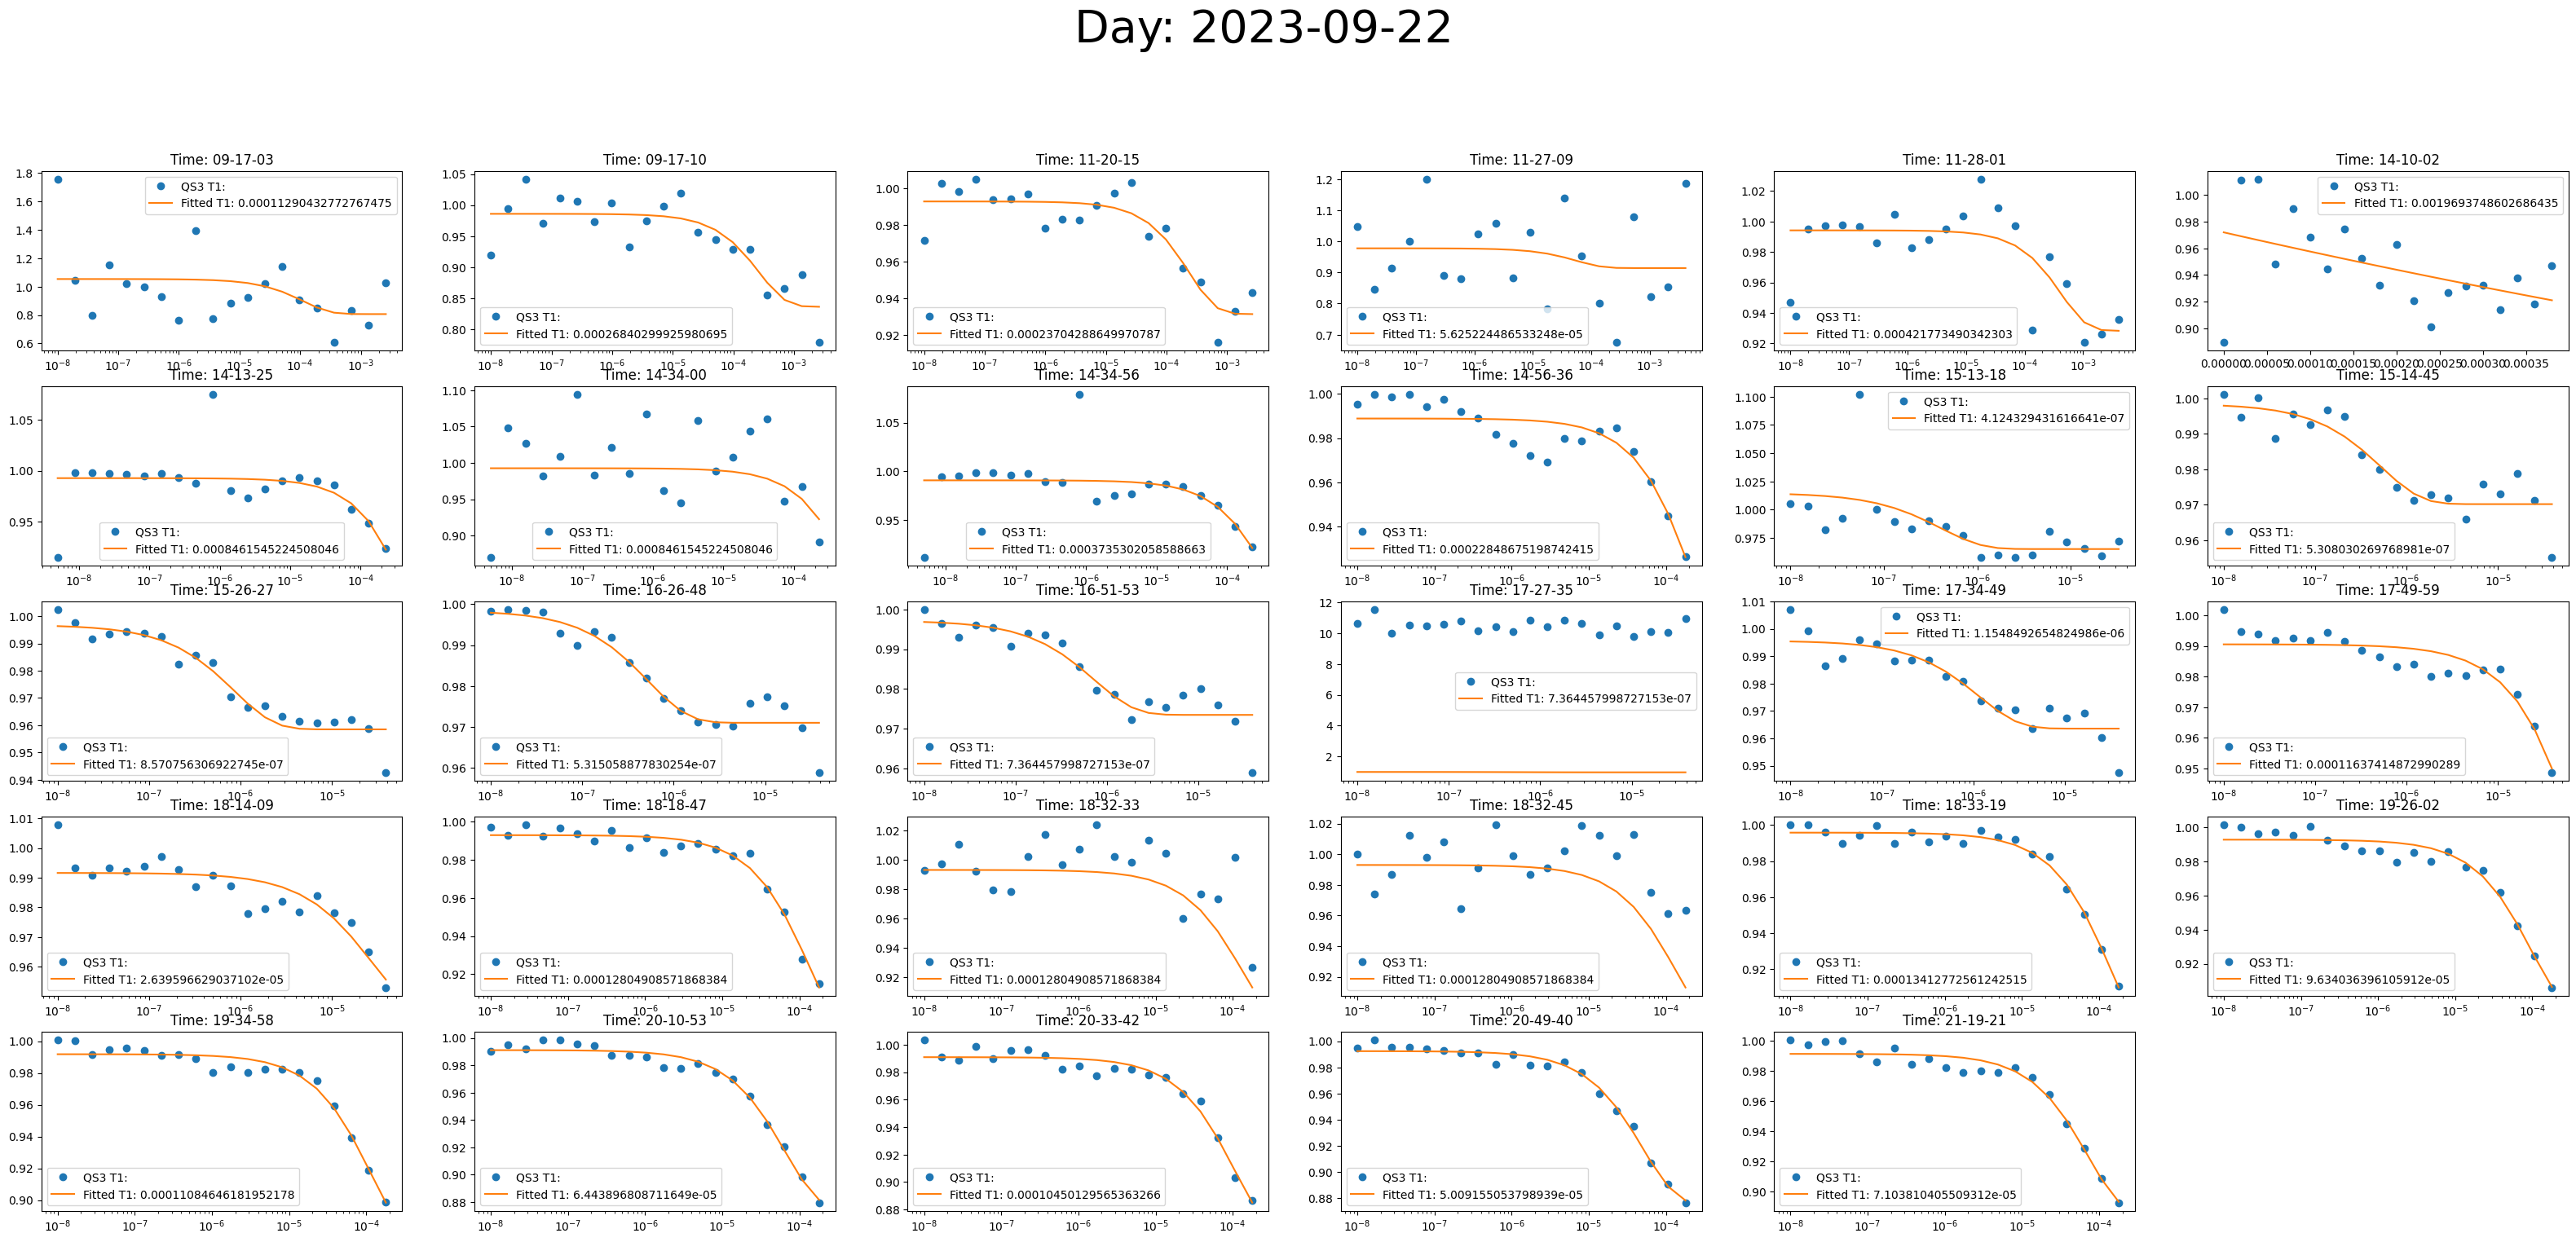

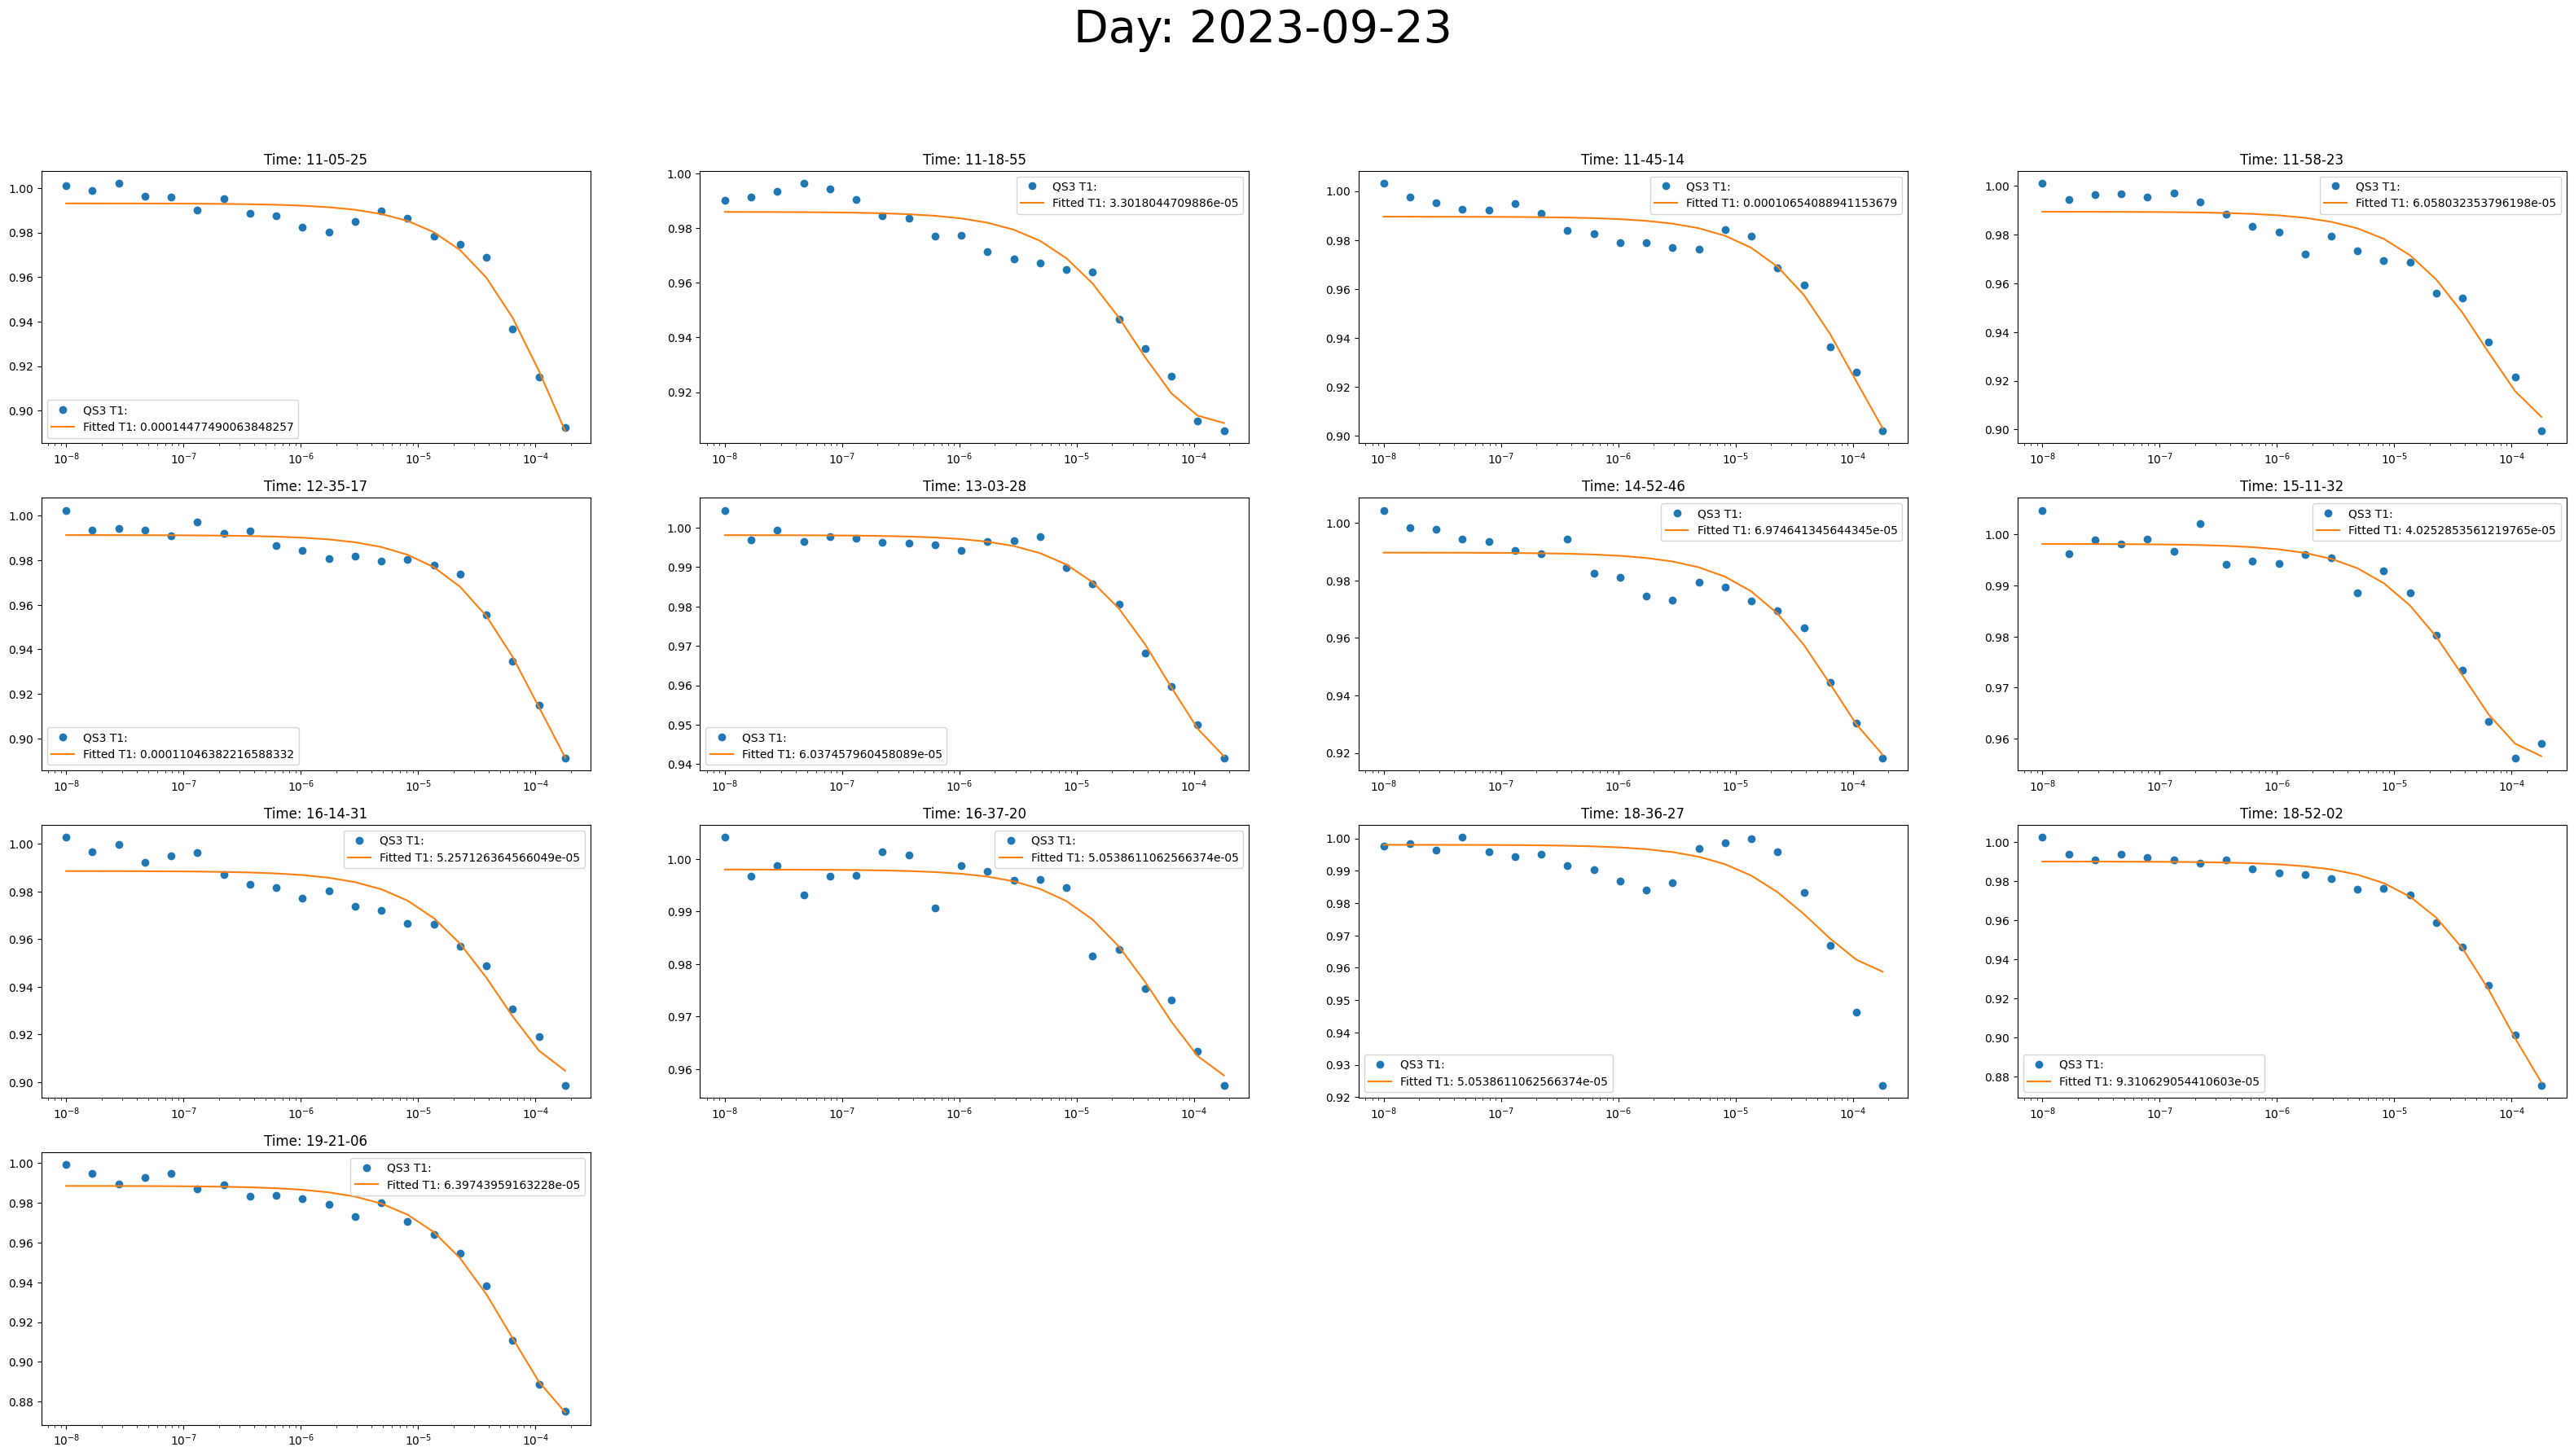

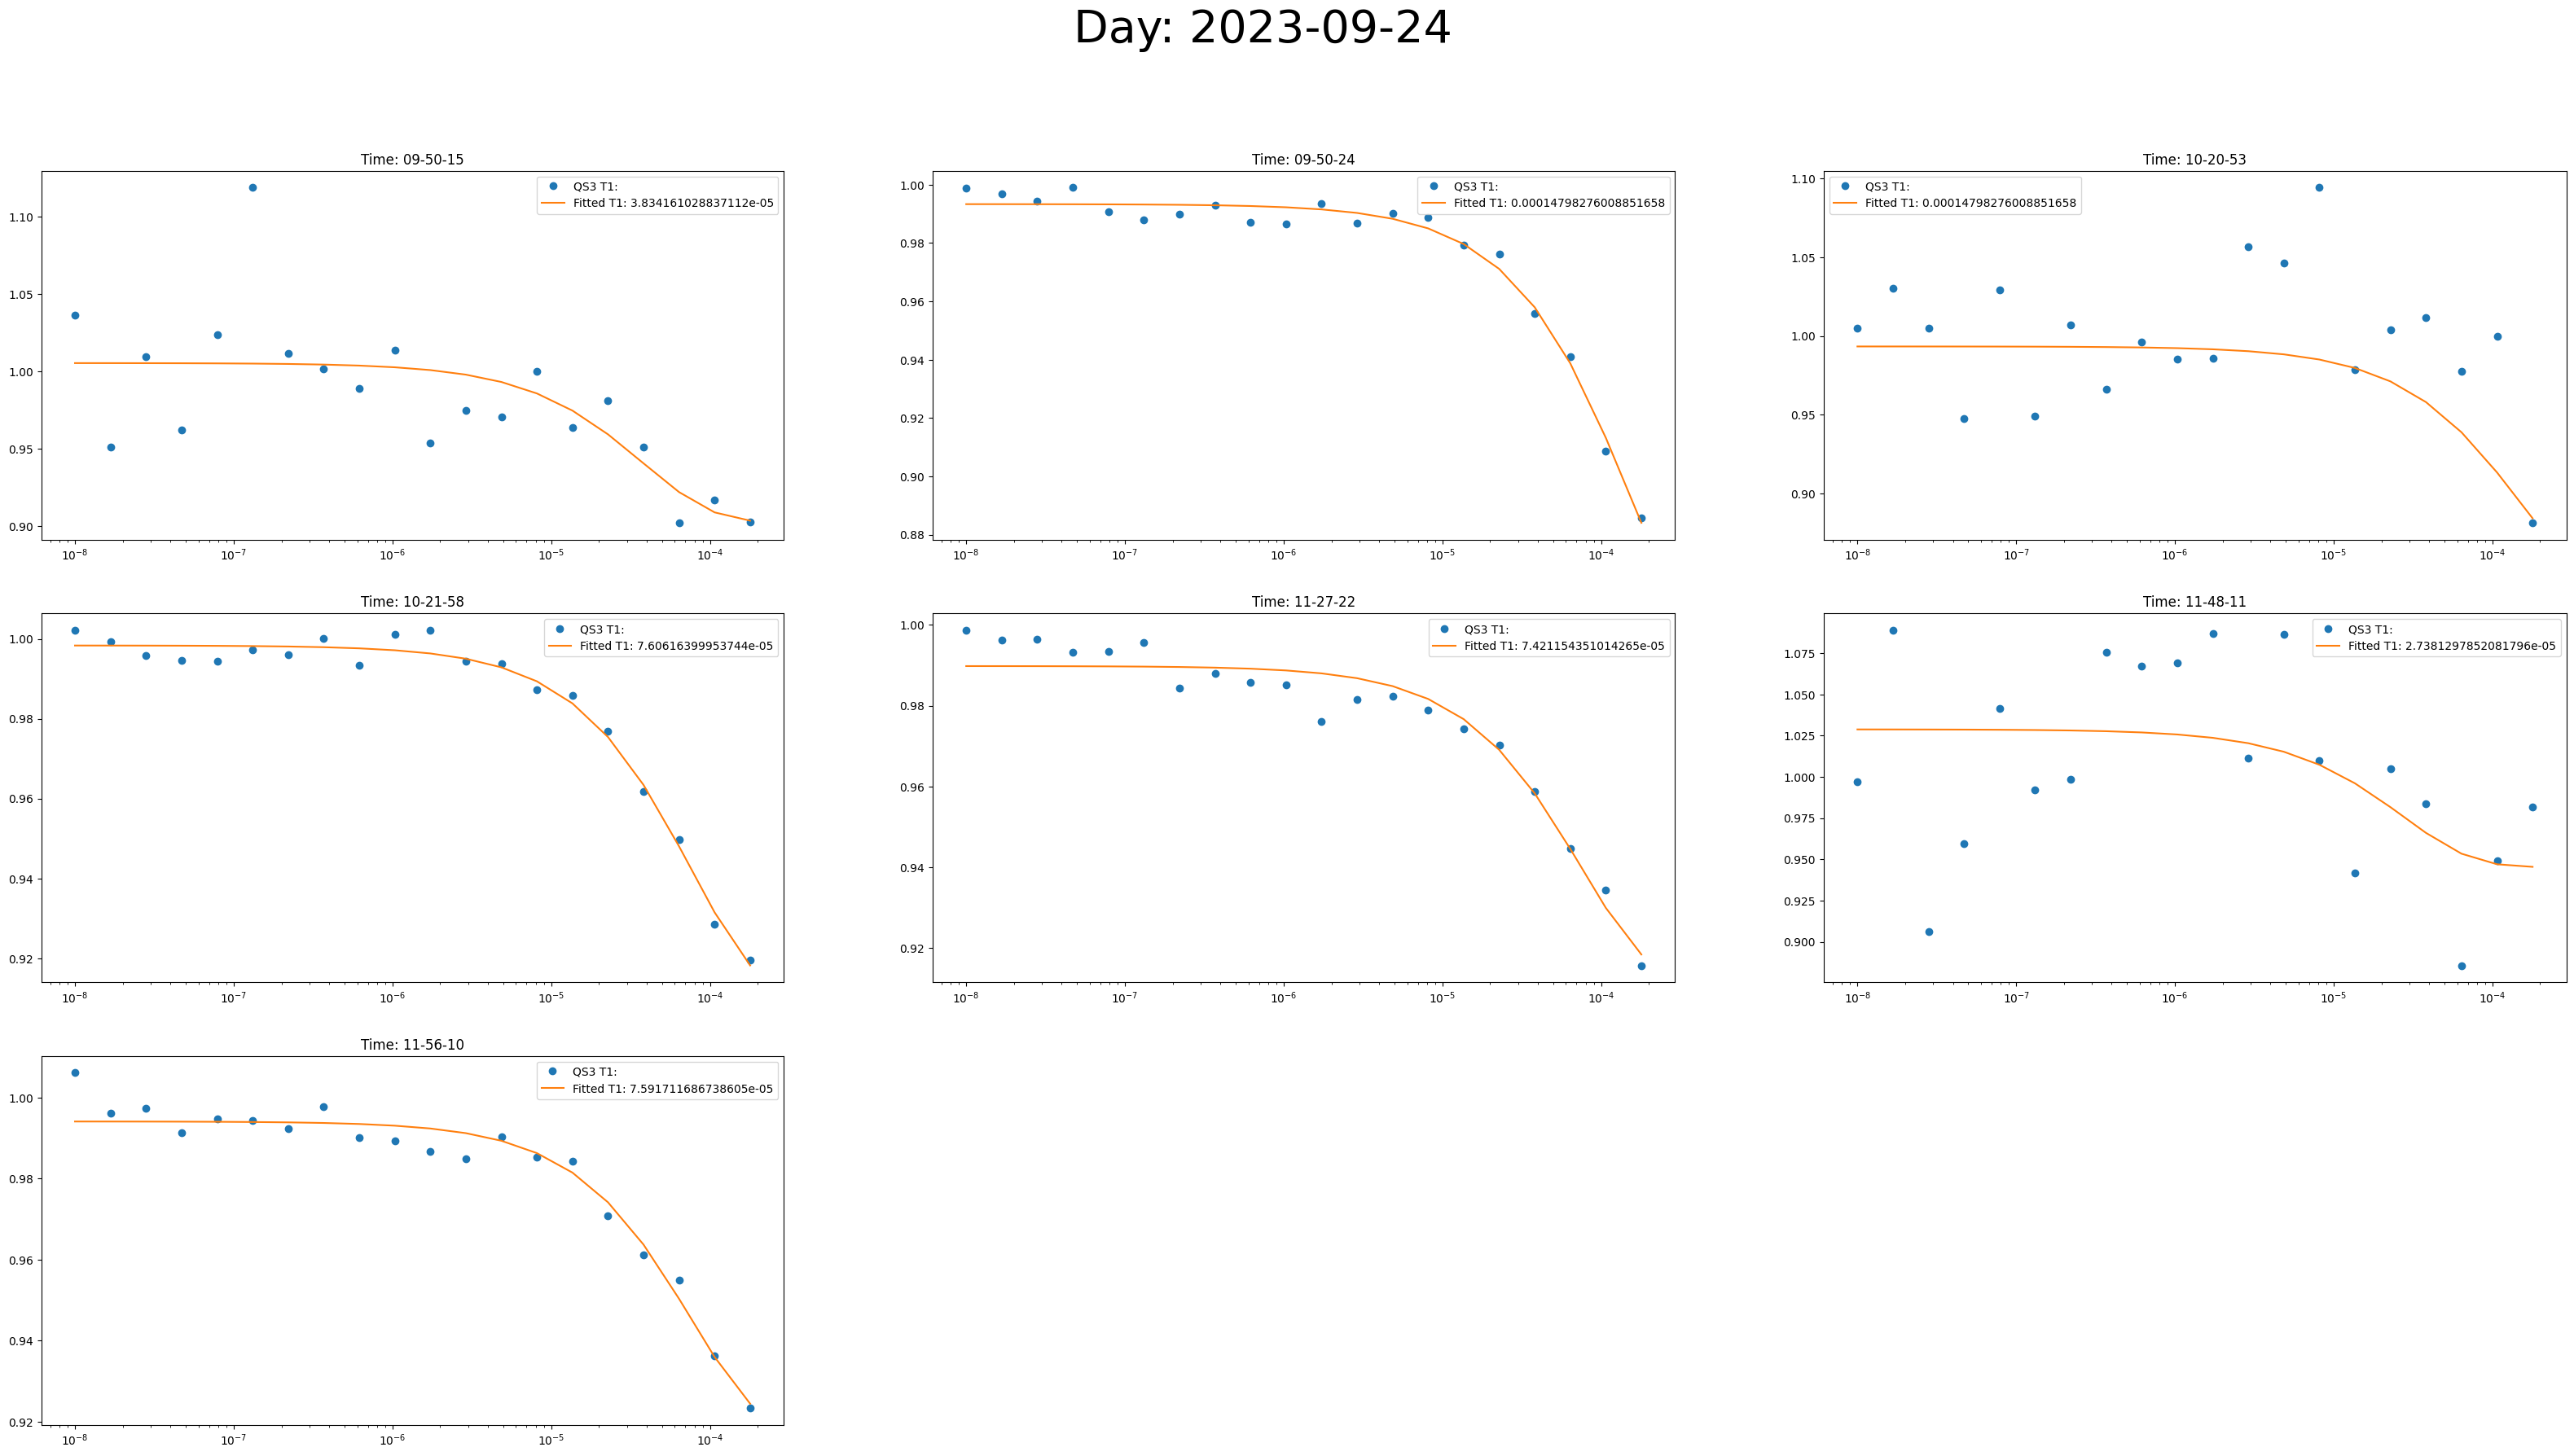

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

In [7]:
#read and plot all pulse experiment data 

savefolder = '/home/julisko/Seafile/My Library/SNVM/20230922_QZabre_Visit_Garnets_SMMs_2DMag/20230922_QZabre_Analysis/Relaxometry'

Pulse_exp_folders = len(Pulse_exp_dayfolders)*[[]]

for Pulse_exp_dayfolders_index in range(len(Pulse_exp_dayfolders)):
    if os.path.isdir(Pulse_exp_dayfolders[Pulse_exp_dayfolders_index]+'/relaxation_laser'):
        Pulse_exp_folders[Pulse_exp_dayfolders_index] = [Pulse_exp_dayfolders[Pulse_exp_dayfolders_index]
                                                        +'/relaxation_laser/'+s 
                                                         for s in sorted(os.listdir(Pulse_exp_dayfolders[
                                                             Pulse_exp_dayfolders_index]+'/relaxation_laser'))]
        #print('\n')
        #print(Pulse_exp_folders[Pulse_exp_dayfolders_index])

nr_of_meas = 0
for day_index in range(len(Pulse_exp_folders)):
    for measurement_index in range(len(Pulse_exp_folders[day_index])):
        nr_of_meas+=1

fig_arr = []
nr_meas_perday = []
        
for day_index in range(len(Pulse_exp_folders)):
    
    #print(len(Pulse_exp_folders[day_index]),Pulse_exp_dayfolders[day_index])
    nr_meas_perday.append(len(Pulse_exp_folders[day_index]))
    fig = plt.figure(figsize = (40,20))
    plt.suptitle('Day: ' + str(Pulse_exp_dayfolders[day_index][-10:]),fontsize=40)
    fig_arr.append(fig)
    
    for measurement_index in range(len(Pulse_exp_folders[day_index])):
        #print(Pulse_exp_folders[day_index][measurement_index])
        h5file = h5py.File(Pulse_exp_folders[day_index][measurement_index]+'/seq0/eval/relaxation.h5')
        
        delays = pSd.ExtractData(h5file, datatype = 'delay')[0][0]
        ms0s = pSd.ExtractData(h5file, datatype = 'ms0')[0][0]
        ref0s = pSd.ExtractData(h5file, datatype = 'ref0')[0][0]
        contrasts = pSd.ExtractData(h5file, datatype = 'contrastms0')[0][0]
        
        if not np.isnan(contrasts).any():
            if not np.isinf(contrasts).any():
                if len(contrasts)>4:
                    p0 = [1/8,3e-4,0,0.9]
                    lowerbounds = [-np.inf,0,-np.inf,-np.inf]
                    upperbounds = [np.inf,np.inf,np.inf,np.inf]
                    try:
                        popt, pcov = curve_fit(exponential,delays[:], contrasts[:],p0=p0,bounds=[lowerbounds,upperbounds])
                    except:
                        pass
                    ax = fig.add_subplot(ceil(np.sqrt(nr_meas_perday[day_index])),
                                         ceil(np.sqrt(nr_meas_perday[day_index])),
                                         measurement_index+1)
                    ax.set_title('Time: ' + str(Pulse_exp_folders[day_index][measurement_index][-25:-17]))
                    #plt.plot(np.logspace(-6,-2,200),exponential(np.logspace(-6,-2,200),*popt),'-')
                    QS3_file, metadata = pSd.ReadSNVMfile(Pulse_exp_folders[day_index][measurement_index])
                    if 'relaxationParameters' in metadata:
                        delaytime_scaling = metadata['relaxationParameters']['sampling']
                        #print(delaytime_scaling)
                        if delaytime_scaling == 0:
                            ax.set_xscale('log')
                    ax.plot(delays[:],contrasts[:],'o',label='QS3 T1: ')#+str(QS3_file['data']['Relaxation:t1']))
                    ax.plot(delays[:],exponential(delays[:],*popt),'-',label='Fitted T1: '+str(popt[1]))
                    #ax.plot(np.logspace(-7,-3,len(contrasts)),contrasts[:],'o',label='QS3 T1: '+str(QS3_file['data']['Relaxation:t1']))
                    #ax.plot(np.logspace(-7,-3,200),exponential(np.logspace(-7,-3,200),*popt),'-',label='Fitted T1: '+str(popt[1]))
                    ax.legend()
                    #ax.plot(np.logspace(-7,-3,200),exponential(np.logspace(-7,-3,200),*popt),'-')
                    
                    #min_array = np.where(exponential(delays[:],*popt)>0.95*np.max(exponential(delays[:],*popt)),True,False)
                    #max_array = np.where(exponential(delays[:],*popt)>1.05*np.min(exponential(delays[:],*popt)),True,False)
                    min_array = np.where(exponential(np.logspace(-9,-1,200),*popt)>0.95*np.max(exponential(np.logspace(-9,-1,200),*popt)),True,False)
                    max_array = np.where(exponential(np.logspace(-9,-1,200),*popt)>1.05*np.min(exponential(np.logspace(-9,-1,200),*popt)),True,False)
                    #print('min array' , min_array)
                    #print('max array' , max_array)
                    
                    for tau_index in range(len(min_array)):
                        if not min_array[tau_index]:
                            #tau_min = delays[tau_index]
                            tau_min = np.logspace(-9,-1,200)[tau_index]
                            break
                    
                    for tau_index in range(len(max_array)):
                        if not max_array[tau_index]:
                            #tau_max = delays[tau_index]
                            tau_max = np.logspace(-9,-1,200)[tau_index]
                            break
                    #print(str(Pulse_exp_folders[day_index][measurement_index][-25:-17]) + ' falling length',
                    #      tau_max-tau_min)
                        
    #fig.savefig(savefolder + '/' + str(Pulse_exp_dayfolders[day_index][-10:]) + '_AllRelaxometries_logscaled.png',dpi=120)#,transparent=True)
    plt.show()
